<a href="https://colab.research.google.com/github/hrshah211/Face_And_Mask_Detector/blob/main/Face_Mask_Detection_Model_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face Detection Model Creation**

**Importing the Necessary Modules**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import cv2

**Creating the Model**

In [ ]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32



In [ ]:
import pathlib    ####### makes our directory into a windows path
data_dir = pathlib.Path("<Path to the dataset>")
data_dir

In [ ]:
withmask = list(data_dir.glob('with_mask/*')) ########33 gives all the directory that are of roses

[WindowsPath('C:/Users/ANTHONY/Desktop/CSV&XLSX/face-mask-detector/dataset/with_mask/0-with-mask.jpg'),
 WindowsPath('C:/Users/ANTHONY/Desktop/CSV&XLSX/face-mask-detector/dataset/with_mask/1-with-mask.jpg'),
 WindowsPath('C:/Users/ANTHONY/Desktop/CSV&XLSX/face-mask-detector/dataset/with_mask/10-with-mask.jpg'),
 WindowsPath('C:/Users/ANTHONY/Desktop/CSV&XLSX/face-mask-detector/dataset/with_mask/100-with-mask.jpg'),
 WindowsPath('C:/Users/ANTHONY/Desktop/CSV&XLSX/face-mask-detector/dataset/with_mask/101-with-mask.jpg')]

In [ ]:
nomask = list(data_dir.glob('without_mask/*')) ########33 gives all the directory that are of roses

[WindowsPath('C:/Users/ANTHONY/Desktop/CSV&XLSX/face-mask-detector/dataset/without_mask/0.jpg'),
 WindowsPath('C:/Users/ANTHONY/Desktop/CSV&XLSX/face-mask-detector/dataset/without_mask/1.jpg'),
 WindowsPath('C:/Users/ANTHONY/Desktop/CSV&XLSX/face-mask-detector/dataset/without_mask/10.jpg'),
 WindowsPath('C:/Users/ANTHONY/Desktop/CSV&XLSX/face-mask-detector/dataset/without_mask/100.jpg'),
 WindowsPath('C:/Users/ANTHONY/Desktop/CSV&XLSX/face-mask-detector/dataset/without_mask/101.jpg')]

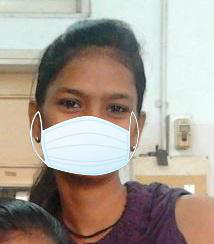

In [ ]:
PIL.Image.open(str(withmask[7]))

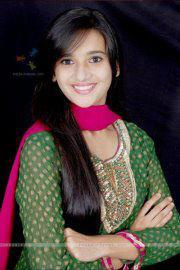

In [ ]:
PIL.Image.open(str(nomask[0]))

In [ ]:
images_dict = {
    'nomask': list(data_dir.glob('without_mask/*')),
    'withmask': list(data_dir.glob('with_mask/*'))
}


In [ ]:
labels_dict = {       #########  labels dictionary randombly
    'nomask': 0,
    'withmask': 1
}
labels_dict["withmask"]

1

In [ ]:
for image_name, images in images_dict.items():
    print(image_name, len(images))

nomask 686
withmask 690


In [ ]:
X, y = [], []
#############################   resizing every image into 180 * 180

for image_name, images in images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224, 224))
        X.append(resized_img)
        y.append(labels_dict[image_name])     ####### y should be a number
        
        ##### so what we do is using labels_dict we save y as numbers

In [ ]:
X = np.array(X)
y = np.array(y)             #######  converetd list into numpy array

In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(y)
labels = to_categorical(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels, random_state=0)

In [ ]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [ ]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

#######################  TUNING MobileNetV2  #############3
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,            ####### WE DONT INCLUDE HEAD, include_top== FALSE
	input_tensor=Input(shape=(224, 224, 3)))



In [ ]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output             #######
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(200, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)        ##### basemodel will be the input and last part of NN will be headmodel

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(aug.flow(X_train_scaled, y_train, batch_size=BS),steps_per_epoch=len(X_train_scaled) // BS,validation_data=(X_test_scaled, y_test),validation_steps=len(X_test_scaled) // BS,epochs=1)

[INFO] compiling model...
[INFO] training head...
32/32 [==============================] - 37s 1s/step - loss: 0.7735 - accuracy: 0.5694 - val_loss: 0.4244 - val_accuracy: 0.9826


In [ ]:
y_test.argmax(axis=1)

array([1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(X_test_scaled, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
predIdxs

[INFO] evaluating network...


array([1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,

In [ ]:
from sklearn import metrics

print(metrics.classification_report(y_test.argmax(axis=1),predIdxs))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       175
           1       0.98      1.00      0.99       169

    accuracy                           0.99       344
   macro avg       0.99      0.99      0.99       344
weighted avg       0.99      0.99      0.99       344



In [ ]:
# show a nicely formatted classification report
print(classification_report(y_test.argmax(axis=1), predIdxs))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       175
           1       0.98      1.00      0.99       169

    accuracy                           0.99       344
   macro avg       0.99      0.99      0.99       344
weighted avg       0.99      0.99      0.99       344



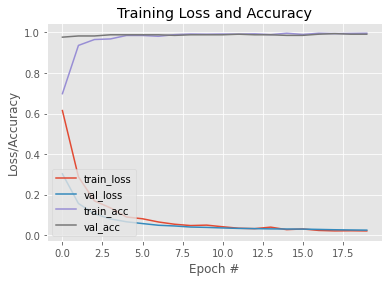

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
########  testing the model

from PIL import Image
address="image_url"
img = Image.open(address)
img.show()


In [ ]:
X = np.array(img)
X=X/255
X.shape

(500, 600, 3)

In [ ]:
resized_img = cv2.resize(X,(224, 224))
resized_img.shape

(224, 224, 3)

In [ ]:
numpyimgdata_reshaped = resized_img.reshape(-1,224, 224, 3)
print(numpyimgdata_reshaped.shape)

(1, 224, 224, 3)


In [ ]:
pred = model.predict(numpyimgdata_reshaped)
pred

array([[0.5317285, 0.4682715]], dtype=float32)

In [ ]:
predIdxs = np.argmax(pred, axis=1)
predIdxs

array([0], dtype=int64)

In [ ]:
########  testing the model

from PIL import Image
address="image_url"
img = Image.open(address)
img.show()
X = np.array(img)
X=X/255
X.shape
resized_img = cv2.resize(X,(224, 224))
resized_img.shape
numpyimgdata_reshaped = resized_img.reshape(-1,224, 224, 3)
print(numpyimgdata_reshaped.shape)
pred = model.predict(numpyimgdata_reshaped)
predIdxs = np.argmax(pred, axis=1)
predIdxs

(1, 224, 224, 3)


array([0], dtype=int64)

In [ ]:
######  saving the model

model.save('mask_det_model.h5') 

INFO:tensorflow:Assets written to: mask_det_model.model\assets
